### Quick Start

The `ssms` package serves two purposes. 

1. Easy access to *fast simulators of sequential sampling models*
   
2. Support infrastructure to construct training data for various approaches to likelihood / posterior amortization

We provide two minimal examples here to illustrate how to use each of the two capabilities.


#### Install 

Let's start with *installing* the `ssms` package.

You can do so by typing,

`pip install git+https://github.com/AlexanderFengler/ssm_simulators`

in your terminal.

Below you find a basic tutorial on how to use the package.

#### Tutorial

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import ssms

#### Using the Simulators

Let's start with using the basic simulators. 
You access the main simulators through the  `ssms.basic_simulators.simulator` function.

To get an idea about the models included in `ssms`, use the `config` module.
The central dictionary with metadata about included models sits in `ssms.config.model_config`. 

In [2]:
# Check included models
list(ssms.config.model_config.keys())[:10]

['ddm',
 'ddm_legacy',
 'angle',
 'weibull',
 'levy',
 'levy_angle',
 'full_ddm',
 'full_ddm_rv',
 'ddm_st',
 'ddm_truncnormt']

In [2]:
# Take an example config for a given model
ssms.config.model_config["levy"]

NameError: name 'ssms' is not defined

In [4]:
ssms.config.model_config["levy"]["params"]

['v', 'a', 'z', 'alpha', 't']

**Note:**
The usual structure of these models includes,

- Parameter names (`'params'`)
- Bounds on the parameters (`'param_bounds'`)
- A function that defines a boundary for the respective model (`'boundary'`)
- The name of the boundary as a string(`'boundary_name'`)
- The number of parameters (`'n_params'`)
- Defaults for the parameters (`'default_params'`)
- The number of choices the process can produce (`'nchoices'`)
- The simulator function that is attached to the model (`'simulator'`)

Some models also include:
- A function for the drift over time (`'drift'`)
- The name of the corresponding drift as a string (`'drift_name'`)

In [5]:
from ssms.basic_simulators.simulator import simulator
from matplotlib import pyplot as plt

sim_out = simulator(
    model="levy",
    theta={"v": 1.1, "a": 1.65, "z": 0.5, "t": 0.3, "alpha": 1.5},
    n_samples=100,
    smooth_unif=False,
)

In [6]:
from ssms.config import model_config

In [7]:
boundary_params = boundary_config_to_function_params(boundary_config)

NameError: name 'boundary_config_to_function_params' is not defined

In [8]:
boundary_params

NameError: name 'boundary_params' is not defined

In [22]:
boundary_config

{'fun': <function ssms.basic_simulators.boundary_functions.constant(t=0)>,
 'params': [],
 'multiplicative': True}

In [7]:
sim_out

{'rts': array([[2.5440197 ],
        [1.2899909 ],
        [1.5310016 ],
        [0.7709975 ],
        [0.7819973 ],
        [0.966995  ],
        [2.733006  ],
        [0.7759974 ],
        [1.346993  ],
        [1.8440161 ],
        [0.58899987],
        [2.1720314 ],
        [1.4309969 ],
        [1.4349971 ],
        [0.8259968 ],
        [0.7629976 ],
        [1.0199943 ],
        [2.5580187 ],
        [1.0769936 ],
        [0.6649989 ],
        [0.8509965 ],
        [1.5040002 ],
        [1.0919933 ],
        [1.5760036 ],
        [0.82399684],
        [1.9300201 ],
        [2.1100285 ],
        [1.5710034 ],
        [0.8269968 ],
        [0.59699976],
        [3.7719307 ],
        [2.9649892 ],
        [0.7029984 ],
        [0.397     ],
        [8.556706  ],
        [0.44600013],
        [0.9119957 ],
        [1.0709937 ],
        [2.181032  ],
        [1.1749923 ],
        [0.73699796],
        [1.5600028 ],
        [0.95599514],
        [0.99299467],
        [1.4949999 ],
   

In [8]:
sim_out["omission_p"].shape

(1, 1)

Text(0, 0.5, 'Density')

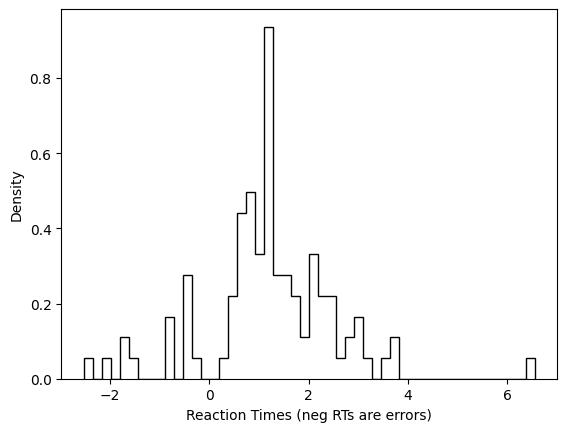

In [9]:
plt.hist(
    sim_out["rts"][sim_out["rts"] != -999] * sim_out["choices"][sim_out["rts"] != -999],
    bins=50,
    histtype="step",
    color="black",
    label="Weibull Deadline",
    density=True,
)
plt.xlabel("Reaction Times (neg RTs are errors)")
plt.ylabel("Density")

The output of the simulator is a `dictionary` with three elements.

1. `rts` (array)
2. `choices` (array)
3. `metadata` (dictionary)

The `metadata` includes the named parameters, simulator settings, and more.

#### Deadlines

You can actually attach a deadline to the simulator of every model, by simply attaching `_deadline` to the `model` argument in the `simulator()` function and passing an extra `deadline` parameter through the `theta` dictionary. Below an example.

In [10]:
sim_out_deadline = simulator(
    model="weibull_deadline",
    theta={
        "v": 0.0,
        "a": 1.65,
        "z": 0.5,
        "t": 0.3,
        "alpha": 0.6,
        "beta": 2.0,
        "deadline": 1.0,
    },
    n_samples=10000,
    smooth_unif=False,
)

Samples that breached the deadline will have an `rt` of `-999`. We can plot the resulting reaction times below.

Text(0, 0.5, 'Density')

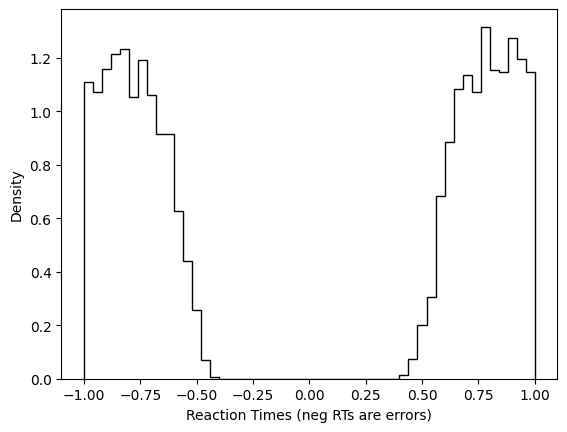

In [11]:
from matplotlib import pyplot as plt

plt.hist(
    sim_out_deadline["rts"][sim_out_deadline["rts"] != -999]
    * sim_out_deadline["choices"][sim_out_deadline["rts"] != -999],
    bins=50,
    histtype="step",
    color="black",
    label="Weibull Deadline",
    density=True,
)
plt.xlabel("Reaction Times (neg RTs are errors)")
plt.ylabel("Density")

#### Using the Training Data Generators

The training data generators sit on top of the simulator function to turn raw simulations into usable training data for training machine learning algorithms aimed at posterior or likelihood armortization.

We will use the `data_generator` class from `ssms.dataset_generators`. Initializing the `data_generator` boils down to supplying two configuration dictionaries.

1. The `generator_config`, concerns choices as to what kind of training data one wants to generate.
2. The `model_config` concerns choices with respect to the underlying generative *sequential sampling model*. 

We will consider a basic example here, concerning data generation to prepare for training [LANs](https://elifesciences.org/articles/65074).

Let's start by peeking at an example `generator_config`.

In [3]:
ssms.config.data_generator_config["lan"]

{'output_folder': 'data/lan_mlp/',
 'model': 'ddm',
 'nbins': 0,
 'n_samples': 100000,
 'n_parameter_sets': 10000,
 'n_parameter_sets_rejected': 100,
 'n_training_samples_by_parameter_set': 1000,
 'max_t': 20.0,
 'delta_t': 0.001,
 'pickleprotocol': 4,
 'n_cpus': 'all',
 'kde_data_mixture_probabilities': [0.8, 0.1, 0.1],
 'simulation_filters': {'mode': 20,
  'choice_cnt': 0,
  'mean_rt': 17,
  'std': 0,
  'mode_cnt_rel': 0.95},
 'negative_rt_cutoff': -66.77497,
 'n_subruns': 10,
 'bin_pointwise': False,
 'separate_response_channels': False,
 'smooth_unif': True}

You usually have to make just few changes to this basic configuration dictionary.
An example below.

In [12]:
from copy import deepcopy

# Initialize the generator config (for MLP LANs)
generator_config = deepcopy(ssms.config.data_generator_config["lan"])
# Specify generative model (one from the list of included models mentioned above)
generator_config["model"] = "ddm_st"
# Specify number of parameter sets to simulate
generator_config["n_parameter_sets"] = 1000
# Specify how many samples a simulation run should entail
generator_config["n_samples"] = 2000
generator_config["n_cpus"] = "all"
generator_config["smooth_unif"] = True

Now let's define our corresponding `model_config`.

In [13]:
model_config = ssms.config.model_config["ddm_st"]
print(model_config)

{'name': 'ddm_st', 'params': ['v', 'a', 'z', 't', 'st'], 'param_bounds': [[-3.0, 0.3, 0.3, 0.25, 0.001], [3.0, 2.5, 0.7, 2.25, 0.25]], 'boundary_name': 'constant', 'boundary': <function constant at 0x1174ed6c0>, 'n_params': 5, 'default_params': [0.0, 1.0, 0.5, 0.25, 0.001], 'nchoices': 2, 'simulator': <cyfunction full_ddm_rv at 0x1422360c0>, 'simulator_fixed_params': {'z_dist': functools.partial(<bound method rv_generic.rvs of <scipy.stats._continuous_distns.norm_gen object at 0x132cbc160>>, loc=0, scale=0), 'v_dist': functools.partial(<bound method rv_generic.rvs of <scipy.stats._continuous_distns.norm_gen object at 0x132cbc160>>, loc=0, scale=0), 's': 1}, 'simulator_param_mappings': {'t_dist': <function <lambda> at 0x142487be0>}}


In [14]:
type(model_config["param_bounds"])

list

We are now ready to initialize a `data_generator`, after which we can generate training data using the `generate_data_training_uniform` function, which will use the hypercube defined by our parameter bounds from the `model_config` to uniformly generate parameter sets and corresponding simulated datasets.

In [15]:
my_dataset_generator = ssms.dataset_generators.lan_mlp.data_generator(
    generator_config=generator_config, model_config=model_config
)

n_cpus used:  12
checking:  data/lan_mlp/


In [16]:
my_dataset_generator.model_config

{'name': 'ddm_st',
 'params': ['v', 'a', 'z', 't', 'st'],
 'param_bounds': [[-3.0, 0.3, 0.3, 0.25, 0.001], [3.0, 2.5, 0.7, 2.25, 0.25]],
 'boundary_name': 'constant',
 'boundary': <function ssms.basic_simulators.boundary_functions.constant(t=0)>,
 'n_params': 5,
 'default_params': [0.0, 1.0, 0.5, 0.25, 0.001],
 'nchoices': 2,
 'simulator': <cyfunction full_ddm_rv at 0x1422360c0>,
 'simulator_fixed_params': {'z_dist': functools.partial(<bound method rv_generic.rvs of <scipy.stats._continuous_distns.norm_gen object at 0x17c8aa860>>, loc=0, scale=0),
  'v_dist': functools.partial(<bound method rv_generic.rvs of <scipy.stats._continuous_distns.norm_gen object at 0x17c8aa860>>, loc=0, scale=0),
  's': 1},
 'simulator_param_mappings': {'t_dist': <function ssms.config.config.<lambda>(st)>},
 'constrained_param_space': {'v': (-3.0, 3.0),
  'a': (0.3, 2.5),
  'z': (0.3, 0.7),
  't': (0.25, 2.25),
  'st': (0.001, 0.25)}}

In [9]:
my_dataset_generator.generator_config

{'output_folder': 'data/lan_mlp/',
 'model': 'full_ddm_rv',
 'nbins': 0,
 'n_samples': 2000,
 'n_parameter_sets': 1000,
 'n_parameter_sets_rejected': 100,
 'n_training_samples_by_parameter_set': 1000,
 'max_t': 20.0,
 'delta_t': 0.001,
 'pickleprotocol': 4,
 'n_cpus': 12,
 'kde_data_mixture_probabilities': [0.8, 0.1, 0.1],
 'simulation_filters': {'mode': 20,
  'choice_cnt': 0,
  'mean_rt': 17,
  'std': 0,
  'mode_cnt_rel': 0.95},
 'negative_rt_cutoff': -66.77497,
 'n_subruns': 10,
 'bin_pointwise': False,
 'separate_response_channels': False,
 'smooth_unif': True}

In [17]:
training_data = my_dataset_generator.generate_data_training_uniform(save=False)

simulation round: 1  of 10
simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
simulation round: 8  of 10
simulation round: 9  of 10
simulation round: 10  of 10


In [18]:
training_data["thetas"][:, model_config["params"].index("st")] < training_data[
    "thetas"
][:, model_config["params"].index("t")]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [10]:
training_data

NameError: name 'training_data' is not defined

In [20]:
my_dict = {
    "v": np.array([-1.022687], dtype=np.float32),
    "t": np.array([1.2465975], dtype=np.float32),
    "a": np.array([1.472519], dtype=np.float32),
    "z": np.array([0.2667516], dtype=np.float32),
    "deadline": np.array([2.0713003], dtype=np.float32),
}

In [31]:
names = [key_ for key_ in my_dict.keys()]
np.tile(np.stack([my_dict[key_] for key_ in names], axis=1), (200, 1)).shape

(200, 10)

`training_data` is a dictionary containing four keys:

1. `data` the features for [LANs](https://elifesciences.org/articles/65074), containing vectors of *model parameters*, as well as *rts* and *choices*.
2. `labels` which contain approximate likelihood values
3. `generator_config`, as defined above
4. `model_config`, as defined above

You can now use this training data for your purposes. If you want to train [LANs](https://elifesciences.org/articles/65074) yourself, you might find the [LANfactory](https://github.com/AlexanderFengler/LANfactory) package helpful.

You may also simply find the basic simulators provided with the **ssm-simulators** package useful, without any desire to use the outputs into training data for amortization purposes.

##### END